In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from scipy.stats import invwishart

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
class MeanFieldVariationalDistribution(nn.Module):
    def __init__(self, nb_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(MeanFieldVariationalDistribution, self).__init__()
        self.device = device
        self.nb_dim = nb_dim
        self.mu = nn.Parameter(torch.Tensor(nb_dim), requires_grad=True)
        self.rho = nn.Parameter(torch.Tensor(nb_dim), requires_grad=True)
        
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu)
            
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma)
        
        rho = torch.log(torch.exp(sigma) - 1)
        
        nn.init.constant_(self.mu, mu)
        nn.init.constant_(self.rho, rho)
        
    def set_mu(self, mu):
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu).float()
        nn.init.constant_(self.mu, mu)
        
        
    def set_rho(self, rho):
        if not torch.is_tensor(rho):
            rho = torch.tensor(rho).float()
        nn.init.constant_(self.rho, rho)
       
    def set_sigma(self, sigma):
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma).float()
        rho = self._sigma_to_rho(sigma)
        self.set_rho(rho)
        
    @property
    def sigma(self):
        return self._rho_to_sigma(self.rho)
        
    def sample(self, n=1):
        sigma = self._rho_to_sigma(self.rho)
        epsilon = torch.randn(size=(n,self.nb_dim)).to(self.device)
        return epsilon.mul(sigma).add(self.mu)
    
    def _rho_to_sigma(self, rho):
        sigma = torch.log(1 + torch.exp(rho))
        return sigma

    def _sigma_to_rho(self, sigma):
        rho = torch.log(torch.exp(sigma) - 1)
        return rho
    
    def log_prob(self, z):
        S = torch.diag(self.sigma)
        return torch.distributions.multivariate_normal.MultivariateNormal(self.mu, scale_tril=S).log_prob(z).unsqueeze(-1)

# Variational Distribution #

In [134]:
D = 250

In [135]:
q = MeanFieldVariationalDistribution(D, mu=-3.0, sigma=3.0)

# Posterior #

In [136]:
S = invwishart.rvs(D, np.identity(D))

In [137]:
def logposterior(x):
    return torch.distributions.multivariate_normal.MultivariateNormal(torch.ones([1,D]), covariance_matrix=torch.tensor(S).float()).log_prob(x).unsqueeze(-1)

In [109]:
import pylab as plt
import numpy as np
T = 100
# Sample data
side = np.linspace(-5,5,T)
X,Y = np.meshgrid(side,side)

In [110]:
Z = np.zeros(X.shape)
for i in range(T):
    for j in range(T):
        x = torch.tensor([X[i,j], Y[i,j]])
        Z[i,j] = torch.exp(logposterior(x))

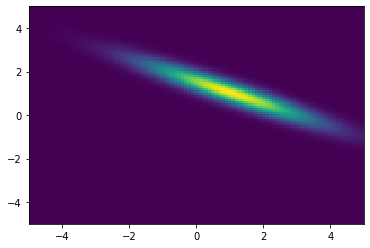

In [111]:
# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,Z)
plt.show()

In [117]:
Z = np.zeros(X.shape)
for i in range(T):
    for j in range(T):
        x = torch.tensor([X[i,j], Y[i,j]])
        Z[i,j] = torch.exp(logposterior(x)) + q.log_prob(x).exp()

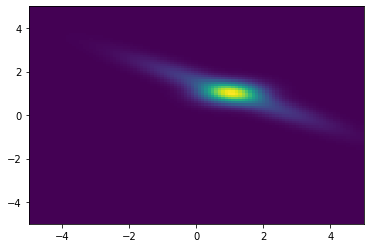

In [118]:
# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,Z)
plt.show()

In [138]:
n_samples_ELBO = 100

In [139]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

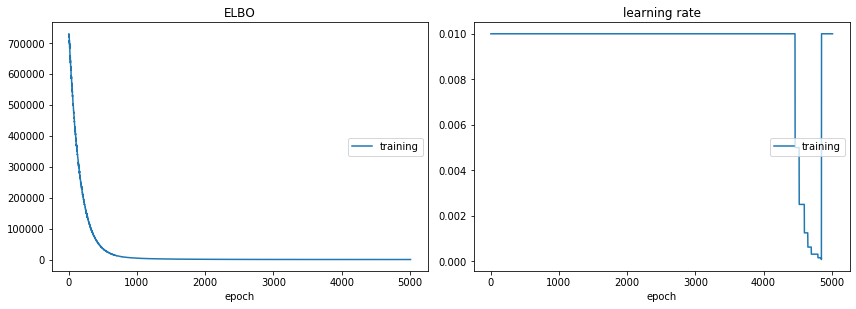

ELBO:
training   (min:  126.782, max: 739426.000, cur:  127.194)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.010)


KeyboardInterrupt: 

In [140]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    z = q.sample(n_samples_ELBO)
    LQ = q.log_prob(z)
    LP = logposterior(z)
    L = (LQ - LP).sum()/n_samples_ELBO

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        if n_samples_ELBO > 1000:
            break
        else:
            optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.8)
            n_samples_ELBO = n_samples_ELBO*10
        